# **REINFORCE** or Monte-Carlo policy gradient

My notes on REINFORCE Algorithm. 

## Symbol Lookup Table


| Symbol             	| Definition                                                                                   	|
|--------------------	|----------------------------------------------------------------------------------------------	|
| $s \in S$          	| $s$ denotes a state.                                                                         	|
| $a \in A$          	| $a$ denotes an action.                                                                       	|
| $r \in R$          	| $r$ denotes a reward.                                                                        	|
| $ \pi(a \vert s) $ 	| Policy function, returns probability of choosing action $a$ in state $s$.                    	|
| $V(s)$             	| State-Value function, Measures how good a state is. (in terms of expected reward).           	|
| $V^\pi (s)$        	| State-Value function, When we are using policy $\pi$.                                        	|
| $Q^\pi$            	| Action-value function, Measures how good an action is.                                       	|
| $Q^\pi (s, a)$     	| Action-value function, How good is to take action $a$ in state $s$ when we use policy $\pi$. 	|
| $\gamma$           	| Discount factor.                                                                             	|
| $G_t$              	| Total return value.                                                                          	|
| $Q^\pi$            	| Action-value function.                                                                       	|
| $V^\pi$            	| State-value function.                                                                        	|


## Definition
[REINFORCE (Monte-Carlo policy gradient)](https://lilianweng.github.io/lil-log/2018/04/08/policy-gradient-algorithms.html#reinforce) relies on an estimated return by Monte-Carlo methods using episode samples to update the policy parameter $\theta$. REINFORCE works because the expectation of the sample gradient is equal to the actual gradient:

$$
\begin{eqnarray} 
\nabla_{\theta}J(\theta) &=&  \mathbb{E}_{\pi} [ Q^{\pi} (s, a) \nabla_\theta \ln \pi_\theta(a \vert s) ]      \nonumber \\
  &=&   \mathbb{E}_{\pi}[G_t \nabla_\theta \ln \pi_\theta ( A_t \vert S_t)]   \nonumber 
\end{eqnarray} 
$$

(Because $ Q^\pi (S_t, A_t) = \mathbb{E}_{\pi}[G_t \vert S_t, A_t] $)

### Process

1. Initialize the policy parameter $\theta$ at random.
2. Generate one trajectory on policy $\pi_{\theta}: S_1, A_1, R_1, S_2, A_2, ... , S_T$.
    3. For $t=1,2,...,T$:
    1. Estimate the return $G_t$.
    1. Update policy parameters: $\theta \leftarrow \theta + \alpha \gamma^t G_t \nabla_{\theta} \ln \pi_{\theta}(A_t \vert S_t)$
    
    

## Sources

This is just re-hash of what's already out there, nothing new per se.

1. [Lilian's Blog](https://lilianweng.github.io/lil-log/2018/04/08/policy-gradient-algorithms.html#reinforce)
1. [PyTorch's Github Repository](https://github.com/pytorch/examples/blob/master/reinforcement_learning/reinforce.py)

In [1]:
# Import all packages we want to use

from itertools import count

import numpy as np
import gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Enough information about ``CartPole-v1``

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of `+1` or `-1` to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of `+1` is provided for every timestep that the pole remains upright. The episode ends when the pole is more than `15` degrees from vertical, or the cart moves more than `2.4` units from the center.

### Summary

| Property           	| Default    	| Note                                                                                      	|
|--------------------	|------------	|-------------------------------------------------------------------------------------------	|
| Max Episode Length 	| `500`      	| Check out this [line](https://github.com/openai/gym/blob/master/gym/envs/__init__.py#L63) 	|
| Action Space       	| `+1`, `-1` 	| The system is controlled by applying a force of `+1` or `-1` to the cart                  	|
| Default reward     	| `+1`       	| A reward of `+1` is provided for every time-step that the pole remains upright            	|

### Sample output

<center><img src='./CartPole.gif'></center>

[Source](https://gym.openai.com/envs/CartPole-v1/)

In [2]:
# Preparing the Cart Pole
env = gym.make('CartPole-v1')
env.seed(0)
torch.manual_seed(0)
gamma = 0.99

In [3]:
# A very simple NN with one hidden layer acts as a brain
# We are simply mapping observation from environment to actions using one hidden layer!
class REINFORCEBrain(nn.Module):
    def __init__(self):
        super(REINFORCEBrain, self).__init__()
        self.affine1 = nn.Linear(4, 128)
        self.affine2 = nn.Linear(128, 2)

        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)
    
    def total_reward_received(self):
        return np.sum(self.rewards)

In [4]:
# No need to use GPU yet! you can call .cuda() after  REINFORCEBrain() to instantiate CUDA version of Brain
policy = REINFORCEBrain()

#Defining an optimizer
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

# Retriving a value for epsilon using numpy's built-ins
eps = np.finfo(np.float32).eps.item()

In [5]:
# Sample from policy π and store some extra info for calculating Loss J(θ)
def select_action(state):
    state = torch.from_numpy(state).float().unsqueeze(0)
    
    # Calculating probabilites of selection each actions
    probs = policy(state)
    
    # Using Categorical helper for sampling and log_probs
    m = Categorical(probs)
    action = m.sample()
    
    # Keeping log probs. Wee need this to calculate J(θ)
    policy.saved_log_probs.append(m.log_prob(action))
    
    # converting tensor to python scalar and returning it 
    return action.item()

In [6]:
def policy_optimize_step():
    R = 0
    policy_loss = []
    rewards = []
    
    # Discounted Reward Calculation
    for r in policy.rewards[::-1]:
        R = r + gamma * R
        rewards.insert(0, R)
    
    # List conversion to Tensor
    rewards = torch.tensor(rewards)
    
    # Normalizing Reward Tensor to have zero mean and unit variance 
    rewards = (rewards - rewards.mean()) / (rewards.std() + eps)
    
    # Calculating Loss per action/reward 
    for log_prob, reward in zip(policy.saved_log_probs, rewards):
        policy_loss.append(-log_prob * reward)
    
    optimizer.zero_grad()
   
    # converting list of tensors to array and summing all of them to create total loss
    policy_loss = torch.cat(policy_loss).sum()
    policy_loss.backward()
    optimizer.step()
    
    # Removing data from last episode
    del policy.rewards[:]
    del policy.saved_log_probs[:]

In [7]:
def train(num_episodes):
    # Length of each episode
    ep_history = []
    # Total reward gathered in each episode
    rw_history = []
    
    for current_episode in range(num_episodes):
        # Reseting the Environment
        state = env.reset()
        
        # Gathering data, with max step of 500
        for t in range(500):
            action = select_action(state)
            state, reward, done, _ = env.step(action)
            policy.rewards.append(reward)
#             env.render()
            if done:
                break
        
        ep_history.append(t)
        rw_history.append(policy.total_reward_received())
        
        # Optimize our policy after gathering a full episode
        policy_optimize_step()

        # Logging
        if (current_episode+1) % 50 == 0:
            print('Episode {}\tLast Epsiode length: {:5d}\t'.format(current_episode, t))
            
    return ep_history, rw_history

In [8]:
episodes_to_train = 350
ep_history, rw_history = train(episodes_to_train)

Episode 49	Last Epsiode length:    17	
Episode 99	Last Epsiode length:   168	
Episode 149	Last Epsiode length:   127	
Episode 199	Last Epsiode length:   310	
Episode 249	Last Epsiode length:   499	
Episode 299	Last Epsiode length:   499	
Episode 349	Last Epsiode length:   499	


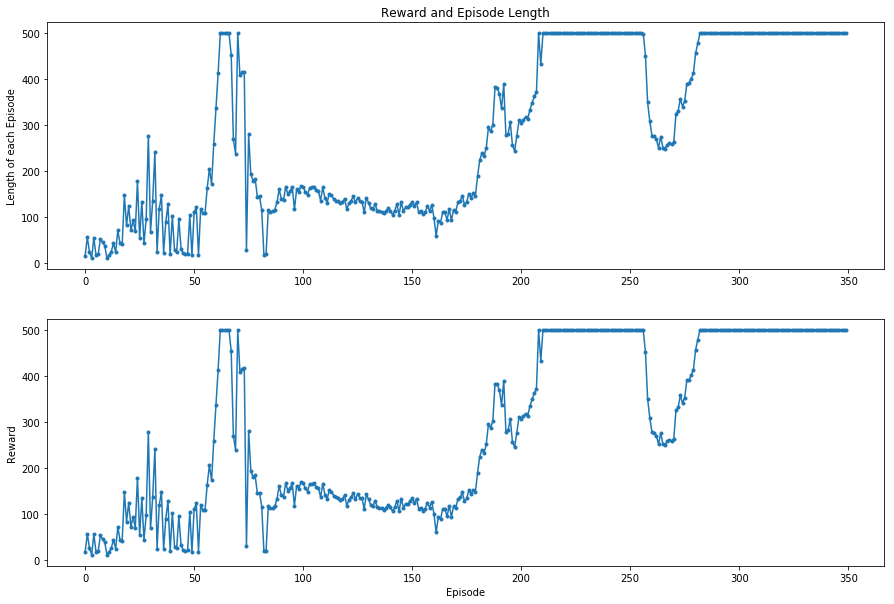

In [9]:
# Making plots larger!
matplotlib.rcParams['figure.figsize'] = [15, 10]

# X Axis of the plots
xx = range(episodes_to_train)

plt.subplot(2, 1, 1)
plt.plot(xx, ep_history, '.-')
plt.title('Reward and Episode Length')
plt.ylabel('Length of each Episode')

plt.subplot(2, 1, 2)
plt.plot(xx, rw_history, '.-')
plt.xlabel('Episode')
plt.ylabel('Reward')

plt.show()

## Notes

1. Reward plot is useless as every value of `rw_history` is equals to `ep_history` minus `1`.
1. Continuing the training will hurt the performance of the model!

### Useful Tools

[Makrdown Table Generator](https://www.tablesgenerator.com/markdown_tables)